In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize()

import shap
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,KFold

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
'''
    记得试一下只有第三个月的
'''

train_app = pd.read_pickle('after_EDA/train_app.pkl')
train_sms = pd.read_pickle('after_EDA/train_sms.pkl')
train_user = pd.read_pickle('after_EDA/train_user.pkl')
train_voc = pd.read_pickle('after_EDA/train_voc.pkl')

test_app = pd.read_pickle('after_EDA/test_app.pkl')
test_sms = pd.read_pickle('after_EDA/test_sms.pkl')
test_user = pd.read_pickle('after_EDA/test_user.pkl')
test_voc = pd.read_pickle('after_EDA/test_voc.pkl')



In [3]:
'''
    第三次修改
    基于第二次
    这次用SMS
'''

'\n    第三次修改\n    基于第二次\n    这次用SMS\n'

In [28]:
combine_train = train_user[['phone_no_m', 'label','city_name', 'county_name', 'idcard_cnt', 'is_arrears','is_null','mean_arpu']]
combine_test = test_user[['phone_no_m', 'city_name', 'county_name', 'idcard_cnt','is_null', 'is_arrears','mean_arpu']]

# merge app
combine_train = pd.merge(combine_train,train_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')
combine_test = pd.merge(combine_test,test_app.groupby('phone_no_m').mean()['flow'].reset_index(),on='phone_no_m',how='inner')

combine_train.rename(columns={'flow':'mean_flow_per_phone'},inplace=True)
combine_test.rename(columns={'flow':'mean_flow_per_phone'},inplace=True)

# merge sms
a = train_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

b = test_sms.groupby(['phone_no_m','sms_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='sms_calltype_id',values = 'opposite_no_m')

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)
combine_test.rename(columns={1:'num_active_sms',2:'num_pass_sms'},inplace=True)


# merge voc
a = train_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
a = a.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

b = test_voc.groupby(['phone_no_m','voice_calltype_id']).count().reset_index()
b = b.pivot(index='phone_no_m',columns='voice_calltype_id',values = ['opposite_no_m','call_dur'])

combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_test = pd.merge(combine_test,b,on='phone_no_m',how='left')

combine_train.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)
combine_test.rename(columns={('opposite_no_m', 'active_call'):'num_active_call',('opposite_no_m', 'passive_call'):'num_pass_call',
                              ('opposite_no_m', 'call_forward'):'num_call_forward',('call_dur', 'active_call'):'dur_active_call',
                             ('call_dur', 'passive_call'):'dur_pass_call',('call_dur', 'call_forward'):'dur_call_forward'},inplace=True)




# 第一次修改内容
# combine_train.drop(columns='mean_arpu',inplace=True)
# combine_test.drop(columns='mean_arpu',inplace=True)
# combine_train['mean_arpu'] = train_user[['arpu_201908','arpu_201909','arpu_201910','arpu_201911']].mean(axis=1)


combine_train.drop(columns=['is_arrears'],inplace=True)
combine_test.drop(columns=['is_arrears'],inplace=True)

combine_train.drop(columns=['county_name'],inplace=True)
combine_test.drop(columns=['county_name'],inplace=True)

In [29]:
'''
    第二次修改内容
'''


# 1. fill mean_flow_per_phone with 0
#  添加每个号码flow的max-min
#  添加每个号码flow的max-mean
#          from 0.81 ---> 0.78
#  删除max-min， mean，只留max-mean
#           from 0.78 --> 0.81
a = train_app.groupby('phone_no_m')['flow'].agg(flow_min='min',
                                        flow_max='max',
                                        flow_mean='mean',
                                        flow_media='median',
                                        flow_var = 'var')
combine_train = pd.merge(combine_train,a,on='phone_no_m',how='inner')

a = test_app.groupby('phone_no_m')['flow'].agg(flow_min='min',
                                        flow_max='max',
                                        flow_mean='mean',
                                        flow_media='median',
                                        flow_var = 'var')
combine_test = pd.merge(combine_test,a,on='phone_no_m',how='inner')

del a
gc.collect()

combine_train.drop(['mean_flow_per_phone','flow_min','flow_media'],axis=1,inplace=True)
combine_test.drop(['mean_flow_per_phone','flow_min','flow_media'],axis=1,inplace=True)



# 起床试试这个
# from 0.78 ---- > 0.829
combine_train['max_mean_flow'] = combine_train['flow_max'] - combine_train['flow_mean']
combine_test['max_mean_flow'] = combine_test['flow_max'] - combine_test['flow_mean']
combine_train.drop(['flow_mean','flow_max'],axis=1,inplace=True)
combine_test.drop(['flow_mean','flow_max'],axis=1,inplace=True)


# 使用mean - median  from 0.829 --- >0.80
# 只是用mean   from 0.80 ---->0.823
# 2. app使用数目
#  用mean - median
# median = 21.750000
# 有8个月，每个号码的平均(/8)  - median
# 获取每个号码的app使用总量
a = pd.DataFrame(train_app.groupby('phone_no_m').count()['busi_name']).reset_index()
combine_train = pd.merge(combine_train,a,how='left',on='phone_no_m')
combine_train.rename(columns={'busi_name':'mean_minus_median_app'},inplace=True)
# 获取每个号码的使用月份
a = train_app[['phone_no_m','month_id']].drop_duplicates().groupby('phone_no_m').count().reset_index()
a.rename(columns={'month_id':'num_month'},inplace=True)
combine_train = pd.merge(combine_train,a,on='phone_no_m',how='left')
combine_train['num_month'] = combine_train['num_month'].apply(lambda x:1 if x == 0 else x)

combine_train['mean_minus_median_app'] = combine_train['mean_minus_median_app']/combine_train['num_month']
# combine_train['mean_minus_median_app'] = (combine_train['mean_minus_median_app'] - 21.75).abs()
# combine_train.drop(columns='num_month',inplace=True)

# median = 16
# test 只有一个月，所以就4月 - median
a = test_app.groupby('phone_no_m').count()['busi_name'].reset_index()
combine_test = pd.merge(combine_test,a,on='phone_no_m',how='left')
combine_test.rename(columns={'busi_name':'mean_minus_median_app'},inplace=True)
# combine_test['mean_minus_median_app'] = (combine_test['mean_minus_median_app'] - 16).abs()

In [30]:
# 1. 之间弄得num sms都是总数，现在把它平均
#    from 0.823 --->0.79
# combine_train['num_active_sms'] = combine_train['num_active_sms']/combine_train['num_month']
# test不用改，因为就一个月

combine_train.drop(columns='num_month',inplace=True)

In [31]:
# 2. active_sms/pass_sms  起床试试
combine_train['ratio_active_pass_sms'] = combine_train['num_active_sms']/combine_train['num_pass_sms']

combine_test['ratio_active_pass_sms'] = combine_test['num_active_sms']/combine_test['num_pass_sms']

combine_train.drop(columns=['num_active_sms','num_pass_sms'],inplace=True)
combine_test.drop(columns=['num_active_sms','num_pass_sms'],inplace=True)

In [32]:
combine_train

,phone_no_m,label,city_name,idcard_cnt,is_null,mean_arpu,num_active_call,num_pass_call,num_call_forward,dur_active_call,dur_pass_call,dur_call_forward,flow_var,max_mean_flow,mean_minus_median_app,ratio_active_pass_sms
0,672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a...,0,绵阳,1,0,45.132812,649.0,609.0,NaN,649.0,609.0,NaN,5317.999023,1530.957520,117.375,0.004255
1,5e1272273e041e82cb275ae877710be98cdaf5b0a8f34d...,0,德阳,1,0,63.941406,43.0,113.0,NaN,43.0,113.0,NaN,26689.375000,3581.066895,168.375,0.005928
2,eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c...,0,成都,2,0,31.783203,779.0,373.0,NaN,779.0,373.0,NaN,5285.788574,1357.017944,106.375,0.075900
3,0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f...,0,成都,2,0,54.070312,1457.0,3149.0,477.0,1457.0,3149.0,477.0,62.375835,60.692074,17.000,0.011106
4,28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d...,0,德阳,1,0,50.000000,19.0,42.0,NaN,19.0,42.0,NaN,286363.125000,13660.660156,145.750,0.001385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,bfc115bb229849f256e52e45cac5c400125cfe24c443f1...,0,宜宾,1,0,1.837524,71.0,1.0,NaN,71.0,1.0,NaN,420424.687500,16992.023438,140.000,0.055124
6102,081f09756ed35d349558170213175ceb91b8d1a0392d1d...,1,天府新区,4,1,307.860156,161.0,1.0,NaN,161.0,1.0,NaN,10.587478,14.392865,10.000,35.652605
6103,fbf1d2b9437078cc8b573528034557f7165cc8ce8776de...,1,未知,4,1,83.125000,236.0,9.0,NaN,236.0,9.0,NaN,0.000038,0.009229,5.000,NaN
6104,aee363f2f1ff659167a2566d7b466fefd27c907a469590...,0,绵阳,3,0,254.359375,1063.0,420.0,NaN,1063.0,420.0,NaN,476793.343750,13133.815430,174.375,0.005114


In [6]:
# 还改了第一次修改的内容 ,
# 用回mean_arpu
# 删掉mean_arpu 和max_arpu
# 因为发现有共线性
# 那个0.89的只用了第三个月，后期可以试试

train_user[train_user['arpu_202003'].isnull()].label.value_counts() # 明天也试试

1    737
Name: label, dtype: int64

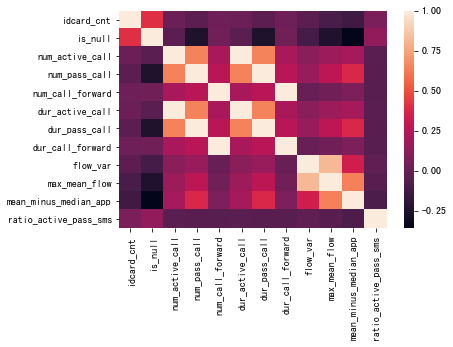

In [8]:
sns.heatmap(combine_train.corr())

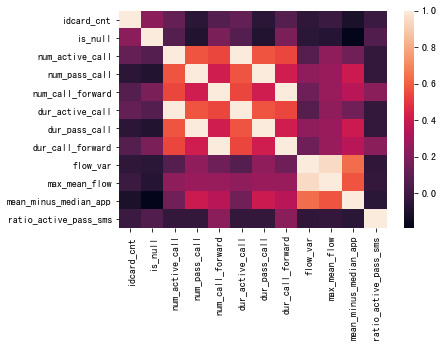

In [9]:
sns.heatmap(combine_test.corr())

In [15]:
y = combine_train['label']
combine_train.drop(columns=['label','phone_no_m'],inplace=True)
combine_test.drop(columns='phone_no_m',inplace=True)

---------
ROC Score:  0.8639184397163121
f1-score-macro:  0.865804993857421


<Figure size 864x432 with 0 Axes>

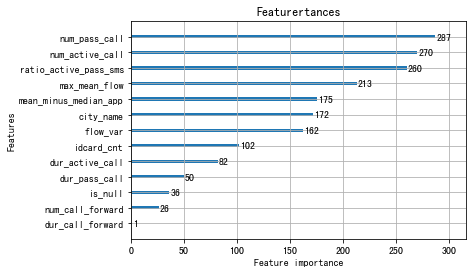

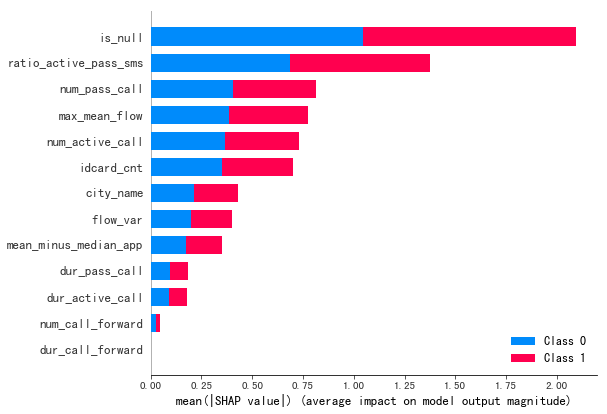

---------
ROC Score:  0.8663778178703553
f1-score-macro:  0.8698690478655009


<Figure size 864x432 with 0 Axes>

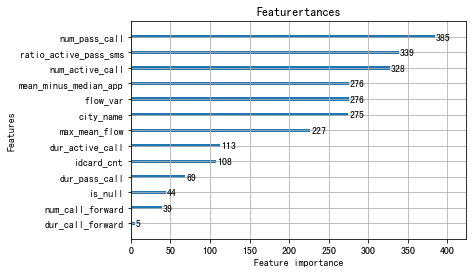

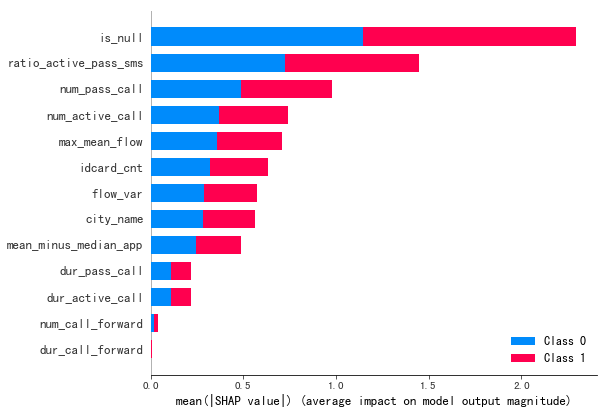

---------
ROC Score:  0.8580978646041968
f1-score-macro:  0.866158224748572


<Figure size 864x432 with 0 Axes>

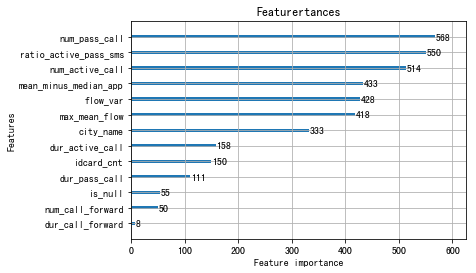

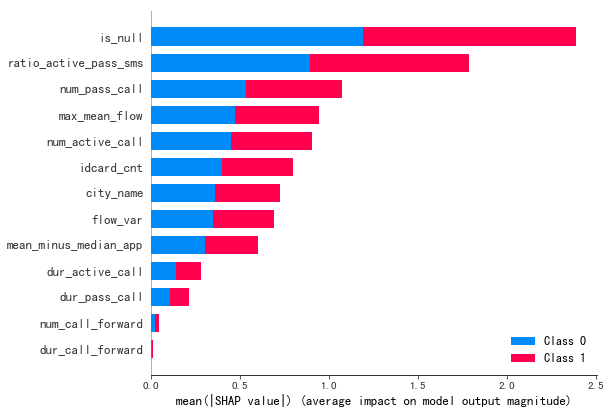

---------
ROC Score:  0.8646890950002745
f1-score-macro:  0.8656305788559829


<Figure size 864x432 with 0 Axes>

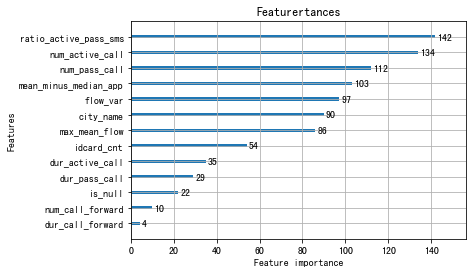

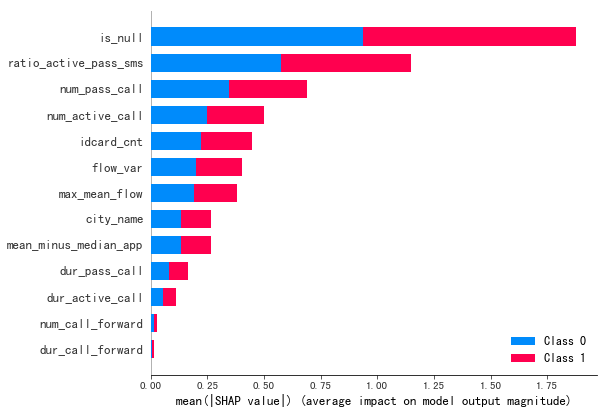

---------
ROC Score:  0.8721742092696371
f1-score-macro:  0.8773986650839674


<Figure size 864x432 with 0 Axes>

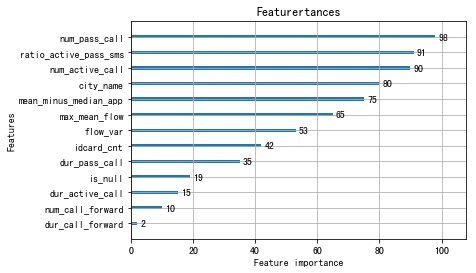

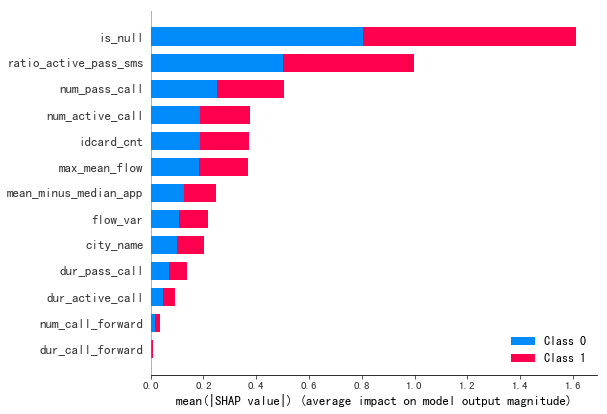

avg +++++++++++++++++++++++++++
ROC Score:  0.8650514852921551
f1-score-macro:  0.8689723020822889
tn:  767.8
fp:  61.0
fn:  77.0
tp:  315.4
precision:  0.8381798984925093
recall:  0.8037081874141212


In [23]:
'''
    baseline3

'''
def score_trans(y):
    res = []
    for x in y:
        if x < 0.5:
            res.append(0)
        else:
            res.append(1)
    return res


category_feature = []
for x in combine_train.select_dtypes(include='object').columns:
    combine_train[x] = combine_train[x].astype('category')
    category_feature.append(x)

# gbm = lgb.LGBMClassifier(objective='binary',is_unbalance=True)

params = {'objective':'binary',
         'is_unbalance':True,
        'metric':'auc',
         'bagging_fraction':0.8,
         'bagging_freq':10,
         'num_leaves':28,
         'max_depth':10,
         'feature_fraction':0.8}
    
    
# X_train, X_test, y_train, y_test = train_test_split(combine_train,y,shuffle=True)

roc,f1_scoret,tnt,fpt,fnt,tpt,precisiont,recallt=0,0,0,0,0,0,0,0

kf = KFold(n_splits=5,shuffle=True)
for train_idx,test_idx in kf.split(combine_train):
    X_train,X_test = combine_train.loc[train_idx],combine_train.loc[test_idx]
    y_train,y_test = y[train_idx],y[test_idx]
    
#     gbm.fit(X_train,y_train)
#     y_pred = gbm.predict(X_test)
    
    trains = lgb.Dataset(X_train,label=y_train,categorical_feature=category_feature,silent=True)
    tests = lgb.Dataset(X_test,label=y_test,categorical_feature=category_feature,silent=True)
    
    gbm = lgb.train(params,trains,num_boost_round=200,valid_sets=[tests],early_stopping_rounds=100,verbose_eval=False)
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    
    y_pred = score_trans(y_pred)
    
    # 乘上一个比例，以确定0.45-0.55之间的为
    print('---------')
    print('ROC Score: ',roc_auc_score(y_test,y_pred))
    print('f1-score-macro: ',f1_score(y_test,y_pred,average='macro'))
    
    
    
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
#     print('tn: ',tn)
#     print('fp: ',fp)
#     print('fn: ',fn)
#     print('tp: ',tp)
#     print('precision: ',tp/(tp+fp))
#     print('recall: ',tp/(tp+fn))
    
    roc += roc_auc_score(y_test,y_pred)
    f1_scoret += f1_score(y_test,y_pred,average='macro')
    tnt += tn
    fpt += fp
    fnt += fn
    tpt += tp
    precisiont += tp/(tp+fp)
    recallt += tp/(tp+fn)
    
    plt.figure(figsize=(12,6))
    lgb.plot_importance(gbm, max_num_features=30)
    plt.title("Featurertances")
    plt.show()
    
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer.shap_values(combine_train)
    shap.summary_plot(shap_values, combine_train)

print('avg +++++++++++++++++++++++++++')
print('ROC Score: ',roc/5)
print('f1-score-macro: ',f1_scoret/5)


print('tn: ',tnt/5)
print('fp: ',fpt/5)
print('fn: ',fnt/5)
print('tp: ',tpt/5)
print('precision: ',precisiont/5)
print('recall: ',recallt/5)



In [24]:
pred = gbm.predict(combine_test)
pred = score_trans(pred)

In [25]:
test_user['label'] = pred

In [26]:
test_user[['phone_no_m','label']].to_csv('baseline_3.csv',index=None)